#Research Question

> A company wants to segment its customers.


> We will take this customer dataset and try several clustering techniques to identify signinificant clusters of customers along with their attributes.





In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
np.random.seed(20)

In [ ]:
# Import dataset
df = pd.read_csv('/content/sample_data/marketing_campaign.csv', delimiter='\t')

#Overview

In [ ]:
# Overview of data
display(df.head())
print('\n', 'Data Information'.center(50, '-') + '\n')
display(df.info())
print('\n', 'Data Dimensions'.center(50,'-'))
print('\n' + 'Row count: {}\nColumn count: {}'.format(df.shape[0], df.shape[1]))

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0



 -----------------Data Information-----------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null

None


 -----------------Data Dimensions------------------

Row count: 2240
Column count: 29


In [ ]:
# Null Value Data Analysis
print('Null Value Analysis:'.center(50,'-') + '\n{}'.format(df.isnull().sum()))

# Only 24 null values, so let's delete all null.
df = df.dropna()
print('\n' + 'Data Dimensions'.center(50,'-') + '\n' + 'Row count: {}\nColumn count: {}'.format(df.shape[0], df.shape[1]))

---------------Null Value Analysis:---------------
ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

-----------------Data Dimensions------------------
Row count: 2216
Column count: 29


#Preprocessing

In [ ]:
# Create age feature
df['Age'] = 2022 - df['Year_Birth']

# Convert income column to int64
df['Income'] = df['Income'].astype(np.int64)

# Create total children feature
df['Children'] = df['Kidhome'] + df['Teenhome']

# Create total expenditure feature
df['TotSpent'] = df[df.columns[9:15]].sum(axis=1)

# Clear up Marital Status feature
df['Marital_Status'] = df["Marital_Status"].replace({"Absurd":"Alone", "YOLO":"Alone"})

# Clear up Education feature
df["Education"] = df["Education"].replace({"Basic":"Undergraduate", "2n Cycle":"Master", "Graduation":"Graduate"})

# Clear up some of the names
for col in df.columns[9:15]:
  n = col[3:]
  df = df.rename(columns={col:n})

# Drop less relevant features
df = df.drop(["Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"], axis=1)

df.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,Wines,Fruits,MeatProducts,FishProducts,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Children,TotSpent
0,Graduate,Single,58138,0,0,58,635,88,546,172,...,0,0,0,0,0,0,1,65,0,1617
1,Graduate,Single,46344,1,1,38,11,1,6,2,...,0,0,0,0,0,0,0,68,2,27
2,Graduate,Together,71613,0,0,26,426,49,127,111,...,0,0,0,0,0,0,0,57,0,776
3,Graduate,Together,26646,1,0,26,11,4,20,10,...,0,0,0,0,0,0,0,38,1,53
4,PhD,Married,58293,1,0,94,173,43,118,46,...,0,0,0,0,0,0,0,41,1,422


In [ ]:
# Descriptive Statistics
print('Numerical:'.center(50,'-'))
display(df.describe())
print('\n' + 'Categorical:'.center(50,'-'))
display(df.describe(include='object'))

--------------------Numerical:--------------------


,Income,Kidhome,Teenhome,Recency,Wines,Fruits,MeatProducts,FishProducts,SweetProducts,GoldProds,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Children,TotSpent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,0.073556,0.074007,0.073105,0.064079,0.013538,0.009477,0.150271,53.179603,0.947202,607.075361
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,0.261106,0.261842,0.260367,0.244950,0.115588,0.096907,0.357417,11.985554,0.749062,602.900476
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,26.000000,0.000000,5.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,45.000000,0.000000,69.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,52.000000,1.000000,396.500000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,63.000000,1.000000,1048.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,129.000000,3.000000,2525.000000



-------------------Categorical:-------------------


,Education,Marital_Status
count,2216,2216
unique,4,6
top,Graduate,Married
freq,1116,857


In [ ]:
# Encode categorical variables
le = LabelEncoder()
ccols = df.select_dtypes(include='object').columns

for c, col in enumerate(ccols):
  df[col] = df[[col]].apply(le.fit_transform)
  key = dict(zip(le.classes_, le.transform(le.classes_)))
  print('Labels for {}:\n'.format(col) + str(key) + '\n')
  if c > 0:
    map2 = pd.DataFrame()
    map2[col] = key.keys()
    map2[col[0:3] + '_Labels'] = key.values()
  else:
    map1 = pd.DataFrame()
    map1[col] = key.keys()
    map1[col[0:3] + '_Labels'] = key.values()

map = pd.concat([map1, map2], axis=1)

Labels for Education:
{'Graduate': 0, 'Master': 1, 'PhD': 2, 'Undergraduate': 3}

Labels for Marital_Status:
{'Alone': 0, 'Divorced': 1, 'Married': 2, 'Single': 3, 'Together': 4, 'Widow': 5}



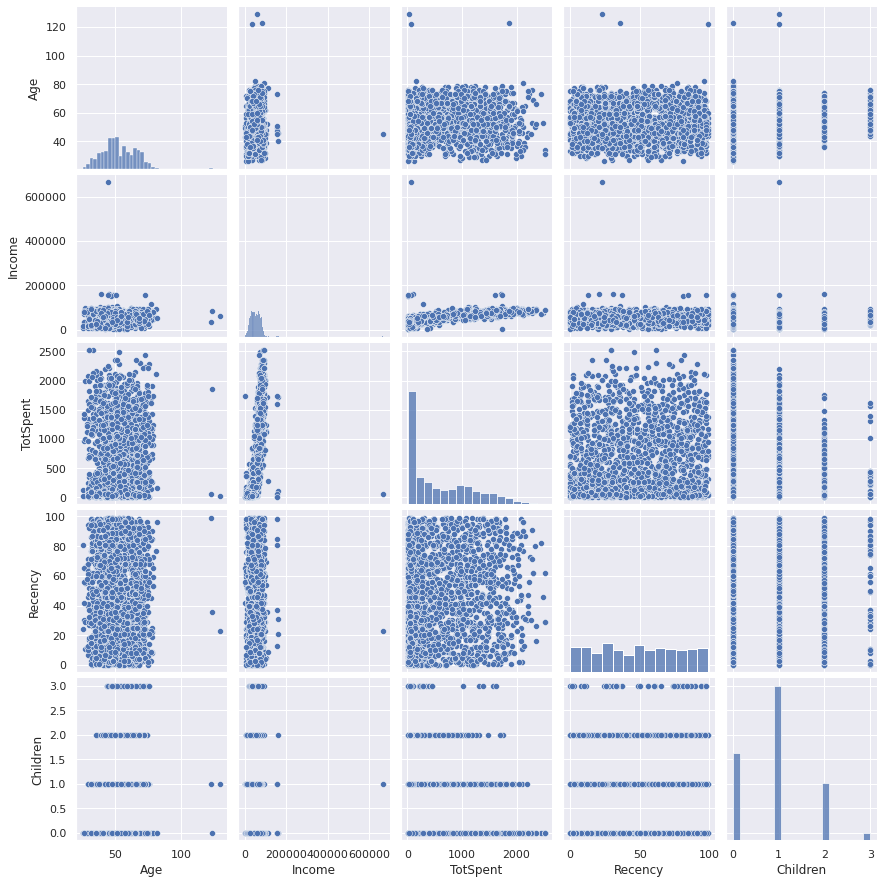

In [ ]:
# There are some signifcant differences in income and age, so let's visualize outliers.
sns.set()
sns.pairplot(df[['Age', 'Income', 'TotSpent', 'Recency', 'Children']])

In [ ]:
# Clean some outliers in age and income.
df = df[df['Age'] < (df['Age'].mean() + 2*df['Age'].std())]
df = df[df['Income'] < (df['Income'].mean() + 2*df['Income'].std())]
print('Data Dimensions'.center(50,'-') + '\n' + 'Row count: {}\nColumn count: {}'.format(df.shape[0], df.shape[1]))

-----------------Data Dimensions------------------
Row count: 2187
Column count: 27


In [ ]:
# Drop deal related columns
data = df.drop(df.columns[17:24], axis=1)
print('Data Dimensions'.center(50,'-') + '\n' + 'Row count: {}\nColumn count: {}'.format(data.shape[0], data.shape[1]) + '\n')
display(data.head())

-----------------Data Dimensions------------------
Row count: 2187
Column count: 20



,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,Wines,Fruits,MeatProducts,FishProducts,SweetProducts,GoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Children,TotSpent
0,0,3,58138,0,0,58,635,88,546,172,88,88,3,8,10,4,7,65,0,1617
1,0,3,46344,1,1,38,11,1,6,2,1,6,2,1,1,2,5,68,2,27
2,0,4,71613,0,0,26,426,49,127,111,21,42,1,8,2,10,4,57,0,776
3,0,4,26646,1,0,26,11,4,20,10,3,5,2,2,0,4,6,38,1,53
4,2,2,58293,1,0,94,173,43,118,46,27,15,5,5,3,6,5,41,1,422


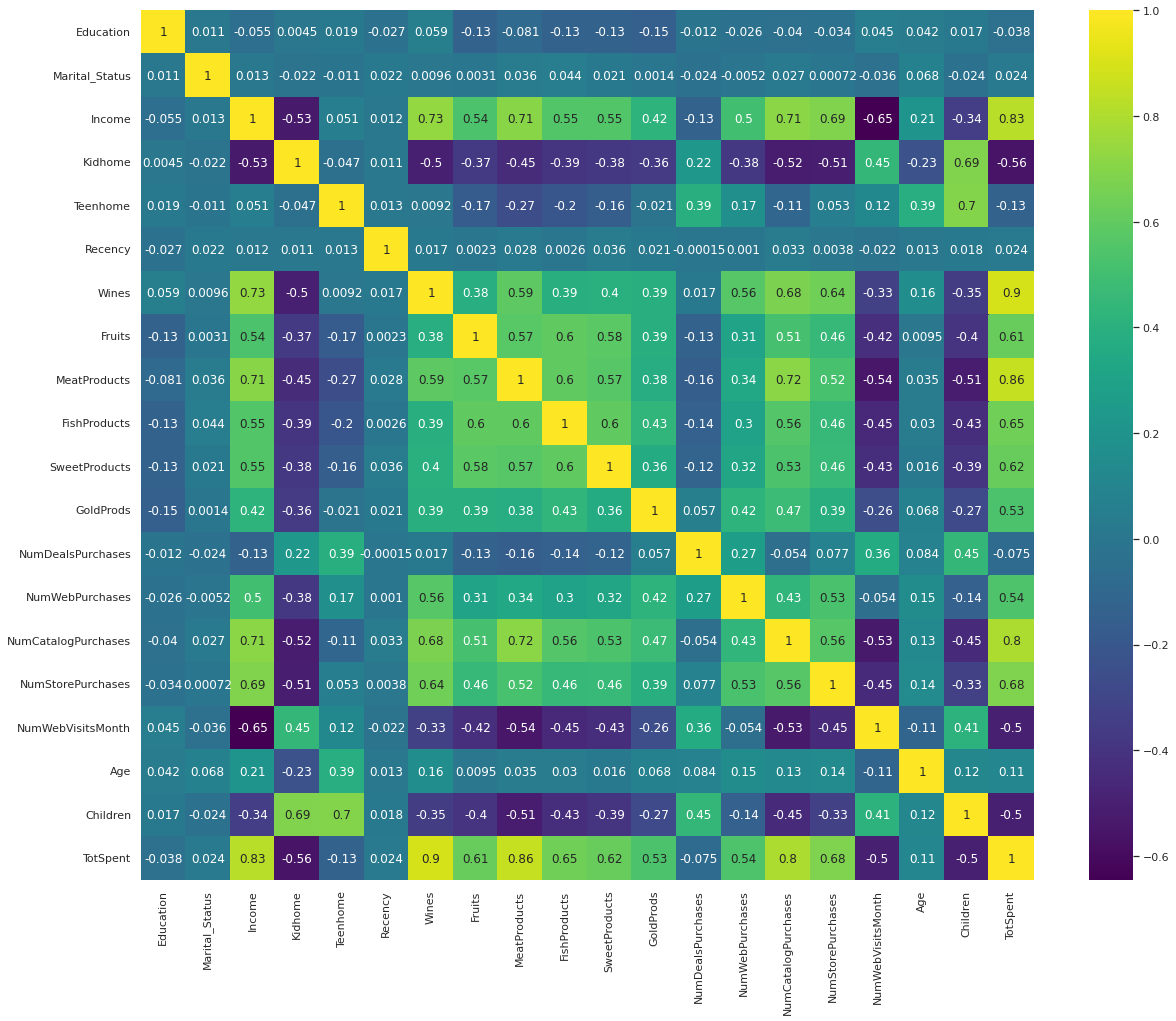

In [ ]:
# Visualize correlation matrix
plt.figure(figsize=(20,16))
sns.heatmap(data.corr(), annot=True, cmap = 'viridis')

In [ ]:
# Scale features
sd = StandardScaler().fit(data)
sdata = pd.DataFrame(sd.transform(data), columns=data.columns)
sdata.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,Wines,Fruits,MeatProducts,FishProducts,SweetProducts,GoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Children,TotSpent
0,-0.867787,0.258241,0.324309,-0.829103,-0.937939,0.310208,0.984526,1.564162,1.753905,2.470091,1.498619,0.848714,0.355325,1.457531,2.651983,-0.559575,0.683139,1.047402,-1.280271,1.688613
1,-0.867787,0.258241,-0.247604,1.030639,0.898473,-0.381427,-0.870876,-0.637416,-0.728417,-0.649597,-0.636851,-0.736654,-0.174032,-1.141880,-0.583558,-1.179373,-0.146875,1.307321,1.396548,-0.959166
2,-0.867787,1.191751,0.977736,-0.829103,-0.937939,-0.796408,0.363085,0.577248,-0.172193,1.350674,-0.145938,-0.040639,-0.703389,1.457531,-0.224053,1.299818,-0.561882,0.354284,-1.280271,0.288121
3,-0.867787,1.191751,-1.202797,1.030639,-0.937939,-0.796408,-0.870876,-0.561500,-0.664061,-0.502789,-0.587759,-0.755988,-0.174032,-0.770535,-0.943063,-0.559575,0.268132,-1.291871,0.058139,-0.915869
4,1.427074,-0.675269,0.331825,1.030639,-0.937939,1.555151,-0.389185,0.425415,-0.213565,0.157851,0.001336,-0.562650,1.414039,0.343498,0.135451,0.060223,-0.146875,-1.031952,0.058139,-0.301384


#PCA

In [ ]:
# Reduce dimensionality of data with PCA
pca = PCA(n_components=3)
pca.fit(sdata)
pcadf = pd.DataFrame(pca.transform(sdata), columns=['c1', 'c2', 'c3'])

Text(0.5, 0.92, 'PCA Data')

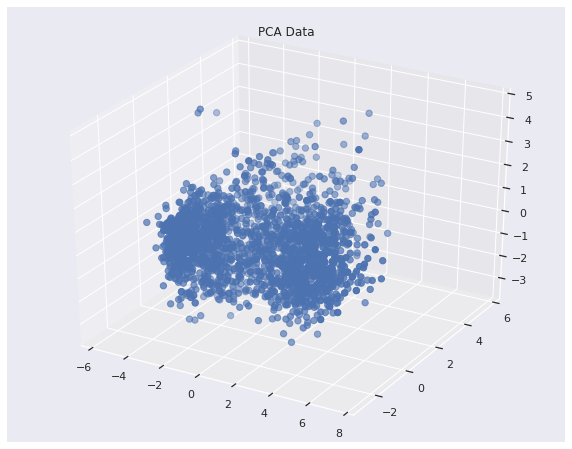

In [ ]:
# Visualize the data in a 3D plot
x = pcadf['c1']
y = pcadf['c2']
z = pcadf['c3']

fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, marker='o', cmap = 'viridis')
ax.set_title("PCA Data")

#t-SNE

In [ ]:
# Reduce dimensionality of daya with TSNE
tsne = TSNE(n_components=3, perplexity=40, n_iter=300)
tsnedf = pd.DataFrame(tsne.fit_transform(sdata), columns=['c1', 'c2', 'c3'])
tsnedf.head()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


,c1,c2,c3
0,1.682618,-1.464927,6.970973
1,-2.913913,5.668425,-4.602153
2,1.646458,-1.915657,2.843169
3,2.331856,-0.502538,-5.917004
4,5.111205,1.905824,-2.694873


Text(0.5, 0.92, 'TSNE Data')

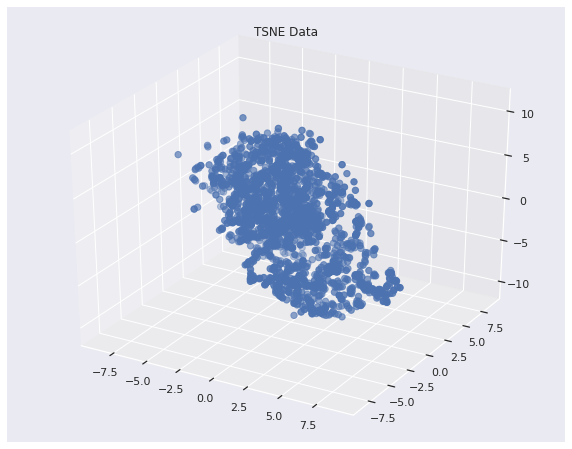

In [ ]:
# Visualize the data in a 3D plot
x1 = tsnedf['c1']
y1 = tsnedf['c2']
z1 = tsnedf['c3']

fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x1, y1, z1, s=40, marker='o', cmap = 'viridis')
ax.set_title("TSNE Data")

#Agglomerative Clustering

Silhouette Score: 0.31589238433252514


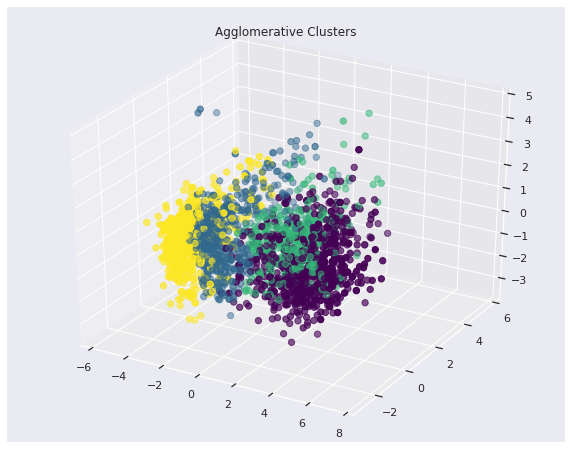

In [ ]:
# Agglomerative Clustering with PCA
ac = AgglomerativeClustering(n_clusters=4)
ac_clusters = ac.fit_predict(pcadf)

# Adding clusters to dataframe
data['ac_pca'] = ac_clusters

# Visualize
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=ac_clusters, marker='o', cmap = 'viridis')
ax.set_title("Agglomerative Clusters")

print('Silhouette Score: {}'.format(silhouette_score(pcadf, ac_clusters)))

In [ ]:
# Agglomerative Clustering without PCA for comparison
ac1 = AgglomerativeClustering(n_clusters=4)
npca_clusters = ac1.fit_predict(sdata)
data['ac_nopca'] = npca_clusters

print('Silhouette Score: {}'.format(silhouette_score(sdata, npca_clusters)))

Silhouette Score: 0.14521896496154404


Text(0.5, 1.0, 'Cluster Distribution')

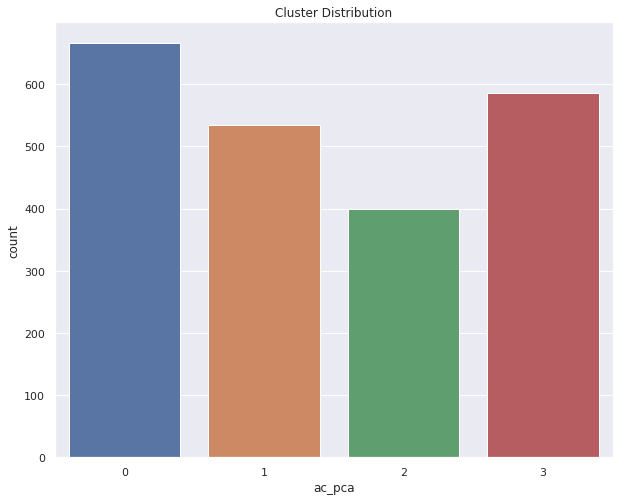

In [ ]:
# Visualizing size of AC clusters
plt.figure(figsize=(10,8))
ct = sns.countplot(x = data['ac_pca'])
ct.set_title('Cluster Distribution')

Text(0.5, 1.0, 'Cluster Distribution According to Income and Total Expenditure')

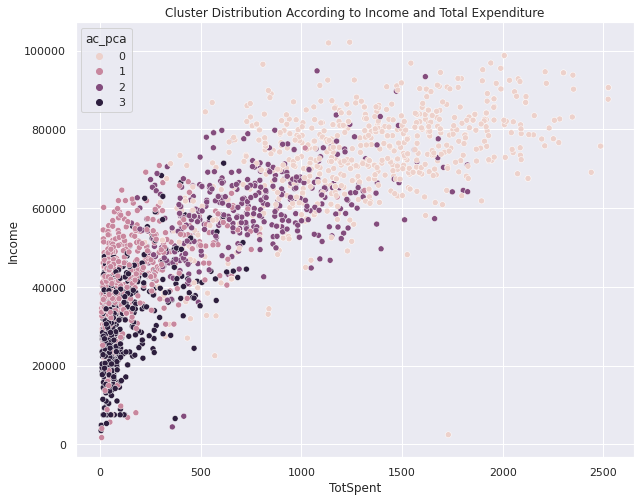

In [ ]:
# Visualizing the differences in customer clusters with respect to income and spending
plt.figure(figsize = (10,8))
sns.scatterplot(data = data, x = data['TotSpent'], y = data['Income'], hue = data['ac_pca'])
plt.title('Cluster Distribution According to Income and Total Expenditure')

The above scatter plot shows clear differences between customer clusters in terms of income and expenses.



*   Cluster 0 generally has high income and expenses are high.
*   Cluster 1 has low to average income but expenses are average to high.
*   Cluster 2 has average to high income and expenses are high.
*   Cluster 3 has low income and low expenses.

Let's see the differences when it comes to promotions.



Text(0.5, 0, '# of Promotions Accepted')

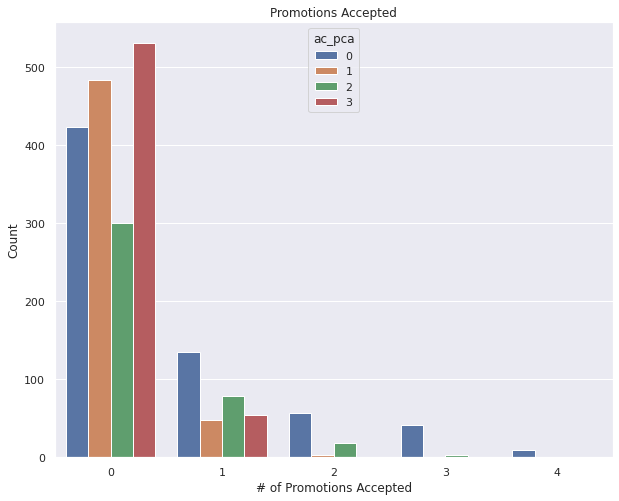

In [ ]:
# Create feature for total accepted promotions
data['TotProms'] = df[df.columns[17:22]].sum(axis=1)

# Visualize accepted promotions in clusters
plt.figure(figsize = (10,8))
sns.countplot(x=data['TotProms'], hue=data['ac_pca'])
plt.title('Promotions Accepted')
plt.ylabel('Count')
plt.xlabel('# of Promotions Accepted')

Not a lot of participation in the promotional campaigns. As expected, the customers who ended up accepting the most promotions are part of the two clusters with the highest income and expenses.

Text(0.5, 0, 'Clusters')

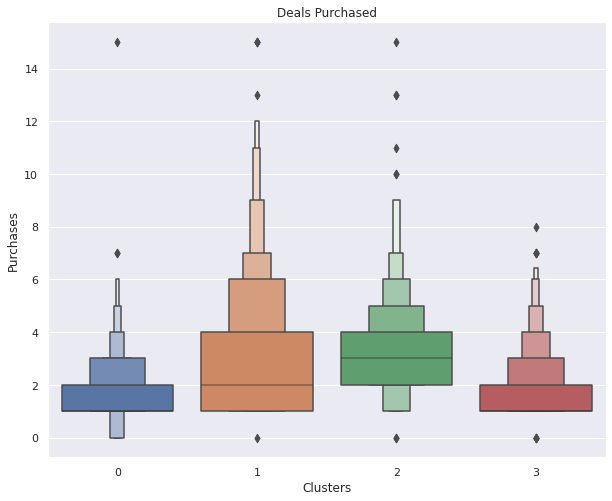

In [ ]:
# Visualize deals purchased in each cluster
plt.figure(figsize = (10,8))
sns.boxenplot(y=data["NumDealsPurchases"],x=data["ac_pca"])
plt.title('Deals Purchased')
plt.ylabel('Purchases')
plt.xlabel('Clusters')

The deals seemed to be a more effective strategy than the campaigns. They're specifically successful cluster 1 and 2, which are more in the middle of the pack in terms of income and expenses. Something to note is that the typical big spenders (cluster 0) are not purchasing these deals.

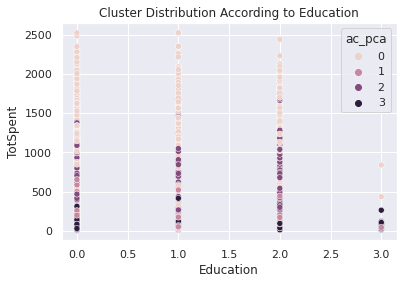

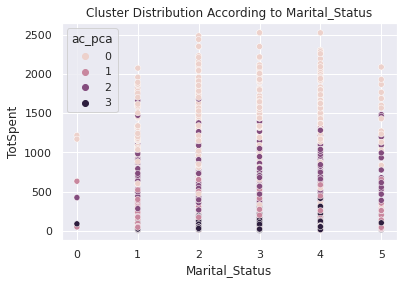

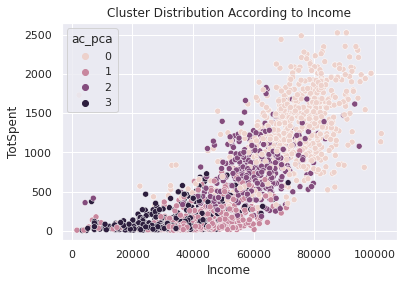

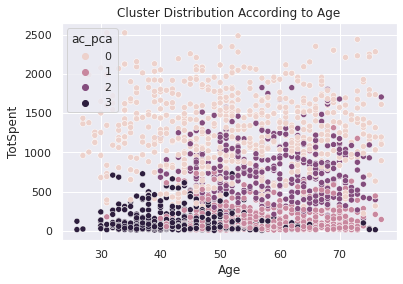

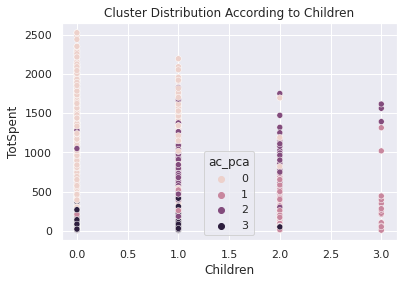

In [ ]:
# Visualize the relationships between demographic variables and clusters
demo = ['Education', 'Marital_Status', 'Income', 'Age', 'Children']

for col in demo:
  sns.scatterplot(data=data, y=data['TotSpent'], x=data[col], hue=data['ac_pca'])
  plt.title('Cluster Distribution According to {}'.format(col))
  plt.show()

From these plots, we can take away a few things about our clusters:

Cluster 0
*   High income.
*   High spending.
*   Unlikely to have children.
*   Age can vary.

Cluster 1
*   Likely has multiple children.
*   Low to average income.
*   Low to average spending.
*   Tends to be older in age.

Cluster 2
*   Average to high income
*   Average to high spending.
*   Like to have children.
*   Tends to be older in age.

Cluster 3
*   Low income.
*   Low spending.
*   Tend to be younger in age.

#K-Means Clustering

Silhouette Score: 0.3457779881131089


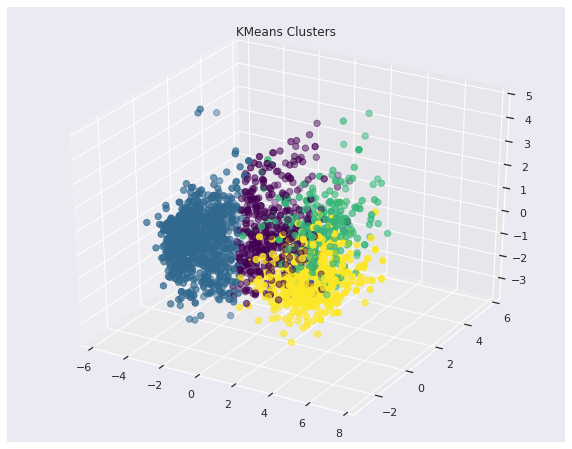

In [ ]:
# K-means with PCA
km = MiniBatchKMeans(n_clusters = 4)
km_clusters = km.fit_predict(pcadf)

# Add clusters to original dataframe
data['km_pca'] = km_clusters

# Visualize the data in a 3D plot
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=km_clusters, marker='o', cmap = 'viridis')
ax.set_title("KMeans Clusters")

print('Silhouette Score: {}'.format(silhouette_score(pcadf, km_clusters)))

In [ ]:
# K-Means without PCA
km = MiniBatchKMeans(n_clusters=4)
npca_kmclusters = km.fit_predict(sdata)
data['km_nopca'] = npca_kmclusters

print('Silhouette Score: {}'.format(silhouette_score(sdata, npca_kmclusters)))

Silhouette Score: 0.18662004896232168


Text(0.5, 1.0, 'Cluster Distribution')

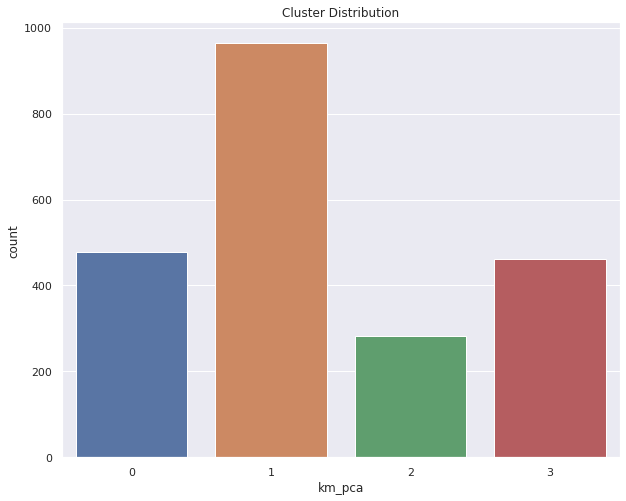

In [ ]:
# Visualizing size of AC clusters
plt.figure(figsize=(10,8))
ct = sns.countplot(x = data['km_pca'])
ct.set_title('Cluster Distribution')

Text(0.5, 1.0, 'Cluster Distribution According to Income and Total Expenditure')

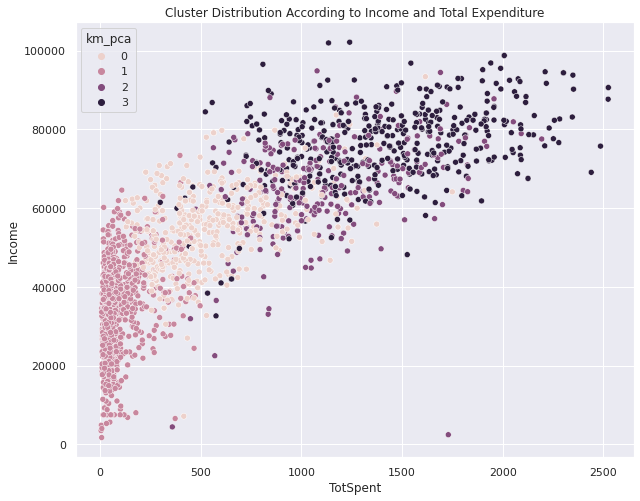

In [ ]:
# Visualizing the differences in customer clusters with respect to income and spending
plt.figure(figsize=(10,8))
sns.scatterplot(data=data, x=data['TotSpent'], y=data['Income'], hue=data['km_pca'])
plt.title('Cluster Distribution According to Income and Total Expenditure')

The above scatter plot shows clear differences between customer clusters in terms of income and expenses.



*   Cluster 0 has average income and expenses.
*   Cluster 1 has low income and expenses.
*   Cluster 2 has average to high income and expenses.
*   Cluster 3 has high income and expenses.

Let's see the differences when it comes to promotions.



Text(0.5, 0, '# of Promotions Accepted')

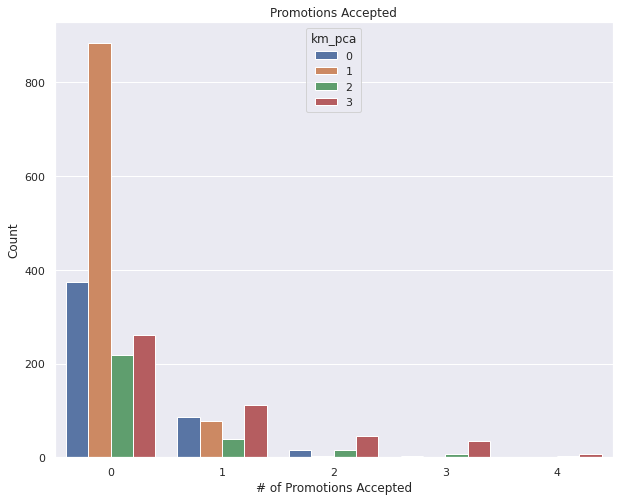

In [ ]:
# Visualize accepted promotions in clusters
plt.figure(figsize = (10,8))
sns.countplot(x=data['TotProms'], hue=data['km_pca'])
plt.title('Promotions Accepted')
plt.ylabel('Count')
plt.xlabel('# of Promotions Accepted')

Not a lot of participation in the promotional campaigns. As expected, the customers who ended up accepting the most promotions are part of the two clusters with the highest income and expenses (clusters 2 and 3).

Text(0.5, 0, 'Clusters')

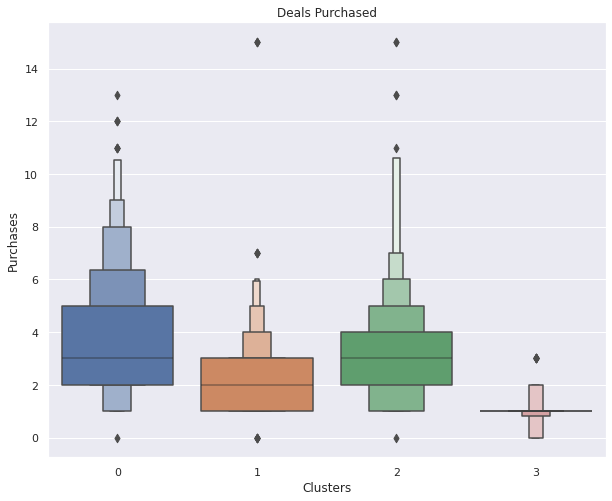

In [ ]:
# Visualize deals purchased in each cluster
plt.figure(figsize = (10,8))
sns.boxenplot(y=data["NumDealsPurchases"],x=data["km_pca"])
plt.title('Deals Purchased')
plt.ylabel('Purchases')
plt.xlabel('Clusters')

The deals seemed to be a more effective strategy than the campaigns. They're specifically successful cluster 0 and 2, which are more in the middle of the pack in terms of income and expenses. Something to note is that the typical big spenders (cluster 3) are not purchasing these deals.

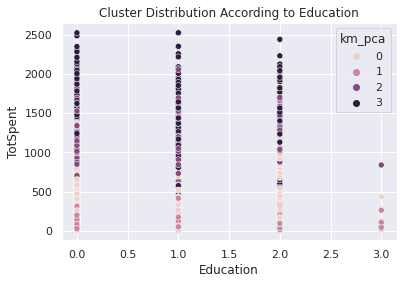

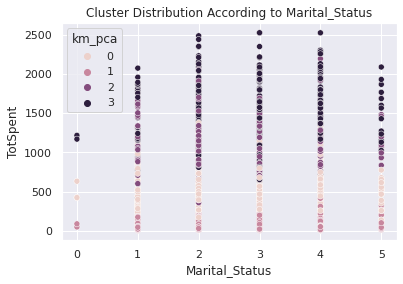

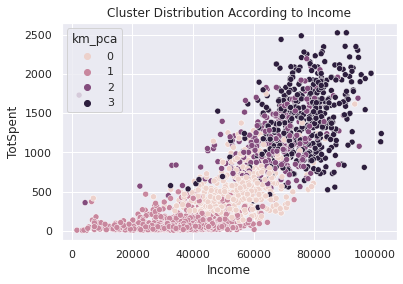

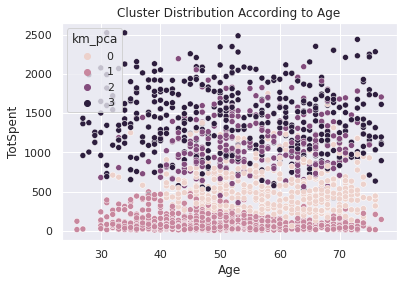

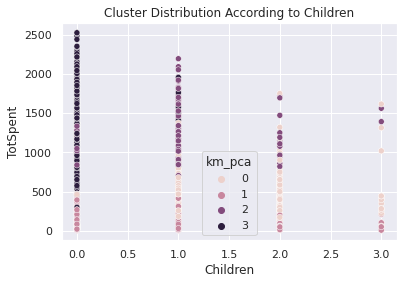

In [ ]:
# Visualize the relationships between demographic variables and clusters
demo = ['Education', 'Marital_Status', 'Income', 'Age', 'Children']

for col in demo:
  sns.scatterplot(data=data, y=data['TotSpent'], x=data[col], hue=data['km_pca'])
  plt.title('Cluster Distribution According to {}'.format(col))
  plt.show()

From these plots, we can take away a few things about our clusters:

Cluster 0
*   Likely has multiple children.
*   Low to average income.
*   Low to average spending.
*   Tends to be older in age.

Cluster 1
*   Low income.
*   Low spending.
*   Tend to be younger in age.

Cluster 2
*   Average to high income
*   Average to high spending.
*   Like to have children.
*   Tends to be older in age.

Cluster 3
*   High income.
*   High spending.
*   Unlikely to have children.
*   Age can vary.


#Conclusion


> According to the silhouette score, the best clusters were produced with the K-M eans algorithm after PCA. Visually, it seems that the K-Means clusters were a bit more seperated than the Agglomerative clusters. Overall, the K-Means clusters were marginally better.


